# setup

In [1]:
import datetime
import json
import os
from collections import Counter
import time

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import praw
from dotenv import load_dotenv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from prawcore.exceptions import RequestException, ResponseException, ServerError
from tqdm import tqdm
from wordcloud import WordCloud
import urllib3.exceptions

In [2]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from pprint import pprint

load_dotenv()
reddit_info = {
    "username": os.getenv("REDDIT_USERNAME"),
    "password": os.getenv("REDDIT_PASSWORD"),
    "personal_use_script": os.getenv("REDDIT_PERSONAL_USE_SCRIPT"),
    "secret": os.getenv("REDDIT_SECRET"),
    "user_agent": os.getenv("REDDIT_USER_AGENT"),
}
pprint(reddit_info)

{'password': 'm2229@t05',
 'personal_use_script': '0Fvnl3H9BuS0YgA20mqw4Q',
 'secret': 'qIhF7rM2xZCu1qHf2cbIBrxenajPGQ',
 'user_agent': 'muehuhu:user',
 'username': 'muehuhu'}


In [4]:
# https://praw.readthedocs.io/en/stable/getting_started/quick_start.html

reddit = praw.Reddit(
    username=reddit_info["username"],
    password=reddit_info["password"],
    client_id=reddit_info["personal_use_script"],
    client_secret=reddit_info["secret"],
    user_agent=reddit_info["user_agent"],
)

print(reddit.read_only)
# Output: False

False


In [5]:
# retrieves relevant keywords
keywords = []
with open('../ai_keywords.txt', 'r', encoding='utf-8') as keywordstxt:
    keywords = [line.rstrip('\n') for line in keywordstxt]
print(keywords)

# Date of ChatGPT release
chatgpt_release_date = datetime.datetime(2022, 11, 30).timestamp()

['Artificial Intelligence', 'AI', 'Machine Learning', 'ML', 'Deep Learning', 'Neural Networks', 'NLP', 'Natural Language Processing', 'Large Language Models', 'LLM', 'Codex', 'Chatbot', 'OpenAI', 'ChatGPT', 'DALL-E', 'GPT', 'Finetuning', 'Prompt', 'Generative AI', 'XLNet']


In [7]:
# CHANGE HERE: maximum subreddit/posts/comments to retrieve
# max: 100 based on the documentation
LIMIT_SUBREDDITS_PER_KEYWORD = 10 # max subreddits per keyword
LIMIT_POSTS = 10
LIMIT_COMMENTS = 10
POSTS_TIME_FILTER = "year" # all/day/hour/month/week/year

## testing to see that it works

In [5]:
for submission in reddit.subreddit("krita").top(limit=10):
    print(submission.title)

Couldn't decide, gold or blue?
My sweat and tears for the past two months
Why is it so bad tho?
Fingergun, by me (@s.ilvestr)
New Landscape I drew in Krita!
Chonker #3
Discord thinks Krita is a game
Just finished this animation on krita 👌👌👌
Made with Krita!!!!!
Cleaning Sunday , made this for a Royal Enfield competition in krita , wish me luck guys :D


# searching for subreddits

In [11]:
# Function to handle retries with exponential backoff
def retry_on_failure(func, max_retries=5, initial_delay=1, backoff_factor=2, *args, **kwargs):
    retries = 0
    delay = initial_delay
    while retries < max_retries:
        try:
            return func(*args, **kwargs)
        except (RequestException, ResponseException, ServerError, urllib3.exceptions.NewConnectionError) as e:
            print(f"Error occurred: {e}. Retrying in {delay} seconds...")
            time.sleep(delay)
            delay *= backoff_factor
            retries += 1
    raise Exception(f"Max retries exceeded for function: {func.__name__}")

# Function to get subreddits
def get_subreddits(keywords, limit_subreddits=5):
    keyword_subreddit_count = {}
    subreddits = []
    for keyword in keywords:
        results = reddit.subreddits.search(keyword, limit=limit_subreddits)
        keyword_subreddit_count[keyword] = 0
        for result in results:
            keyword_subreddit_count[keyword] += 1
            if result.display_name not in subreddits:
                subreddits.append(result.display_name)
    return list(set(subreddits)), keyword_subreddit_count

# Function to get top posts from a subreddit
def get_top_posts(subreddit, limit_posts=10, after=None):
    posts = []
    try:
        for submission in reddit.subreddit(subreddit).top(limit=limit_posts, time_filter=POSTS_TIME_FILTER):
            if after and submission.created_utc < after:
                continue
            posts.append(submission)
    except (RequestException, ResponseException, ServerError) as e:
        print(f"API limit reached, sleeping for 60 seconds: {e}")
        time.sleep(60)
        return get_top_posts(subreddit, limit_posts, after)
    return posts

# Function to get comments from a post
def get_comments(post, limit_comments=5):
    post.comments.replace_more(limit=0)
    comments = []
    for comment in post.comments.list()[:limit_comments]:
        comments.append(comment.body)
    return comments

# Function to generate co-occurrence matrix
def co_occurrence_matrix(texts):
    words = []
    for text in texts:
        words.extend(word_tokenize(text))
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    co_occurrences = Counter()
    for i in range(len(words)):
        for j in range(i + 1, len(words)):
            if words[i] != words[j]:
                co_occurrences[frozenset([words[i], words[j]])] += 1
    return co_occurrences

## get relevant subreddits

In [9]:
subreddits, keyword_subreddit_count = get_subreddits(keywords, limit_subreddits=LIMIT_SUBREDDITS_PER_KEYWORD)
print(f"Subreddits retrieved: {subreddits}")
print(f"Subreddits count by keyword: {keyword_subreddit_count}")

Subreddits retrieved: ['PygmalionAI', 'uncannyvalley', 'generativeAI', 'ChatGPT', 'MachineLearningJobs', 'NLP', 'MobileLegendsGame', 'ChatbotAddiction', 'nlp_knowledge_sharing', 'Crushon', 'learnmachinelearning', 'PromptHero', 'UsefulLLM', 'LearningMachine', 'scholarshipjunkies', 'OpenAI', 'Python', 'SpikingNeuralNetworks', 'FakeCum', 'deepdream', 'Tau40K', 'Futurology', 'OMSCS', 'programming', 'replika', 'AiPornhubvideo', 'SissyGPT', 'LocalLLM', 'StableDiffusion', 'MLA_Official', 'MLBStreams', 'aiArt', 'artificial', 'LoverGPT', 'ResearchML', 'FunMachineLearning', 'dalle3', 'LLMSmut', 'MistralAI', 'WritingPrompts', 'LLMDevs', 'LocalLLaMA', 'tensorflow', 'MLQuestions', 'Prompt', 'GPT_jailbreaks', 'HentaiAndRoleplayy', 'cataclysmddaCODEX', 'unsloth', 'CharacterAi_NSFW', 'NSFWChatBots', 'WarhammerCompetitive', 'OpenAIDev', 'ChatGPTCoding', 'apachespark', 'DeepLearningMemes', 'DirtyWritingPrompts', 'ChaiApp', 'generative', 'SubredditNN', 'ChatGPTPro', 'slatestarcodex', 'technology', 'socce

## get top posts and comments

In [12]:
# Fetch top posts and comments with progress indication
data = {}
post_count = 0
for subreddit in tqdm(subreddits, desc="Processing subreddits"):
    posts = get_top_posts(subreddit, limit_posts=LIMIT_POSTS, after=chatgpt_release_date)
    post_count += len(posts)
    data[subreddit] = []
    for post in tqdm(posts, desc=f"Processing posts in {subreddit}"):
        post_data = {
            "title": post.title,
            "description": post.selftext,
            "comments": get_comments(post, limit_comments=LIMIT_COMMENTS)
        }
        data[subreddit].append(post_data)


# Save results to JSON with proper formatting
with open("reddit_analysis.json", "w", encoding='utf-8') as outfile:
    json.dump(data, outfile, ensure_ascii=False, indent=4)

# Analysis Summary
print(f"Number of subreddits analyzed: {len(subreddits)}")
print(f"Number of posts analyzed: {post_count}")

Processing subreddits:   0%|          | 0/135 [00:00<?, ?it/s]


TypeError: fetch_comments() got an unexpected keyword argument 'post'

# data analysis

In [ ]:
# Generate co-occurrence matrices for each subreddit
co_occurrences = {}
all_texts = []
for subreddit, posts in data.items():
    for post in posts:
        texts = [post["title"], post["description"]] + post["comments"]
        all_texts.extend(texts)
        matrix = co_occurrence_matrix(texts)
        if subreddit not in co_occurrences:
            co_occurrences[subreddit] = Counter()
        co_occurrences[subreddit] += matrix

In [8]:
# Word frequency analysis
all_words = [word.lower() for text in all_texts for word in word_tokenize(text) if word.isalpha() and word.lower() not in stop_words]
word_freq = Counter(all_words)

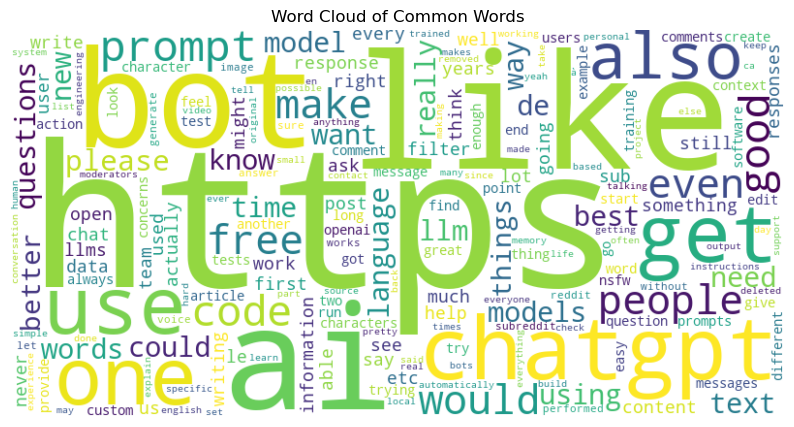

In [9]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Common Words')
plt.show()

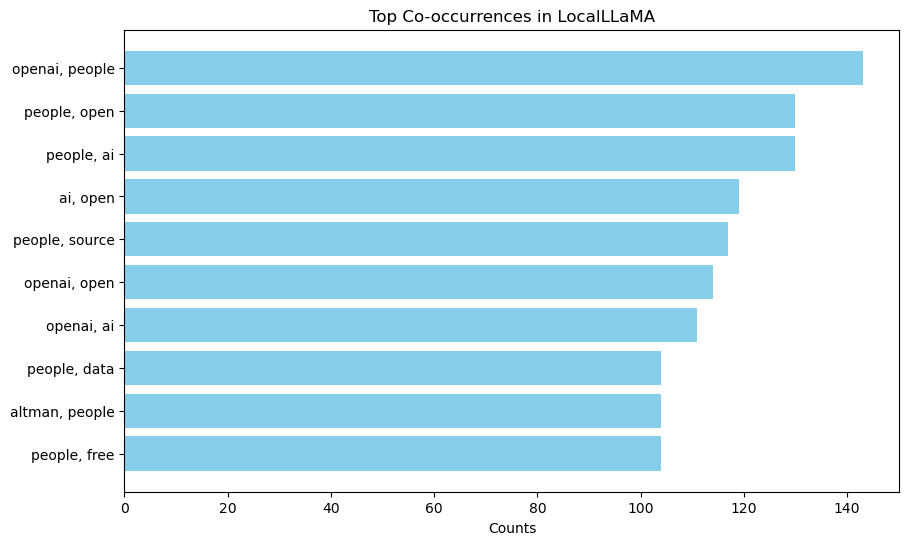

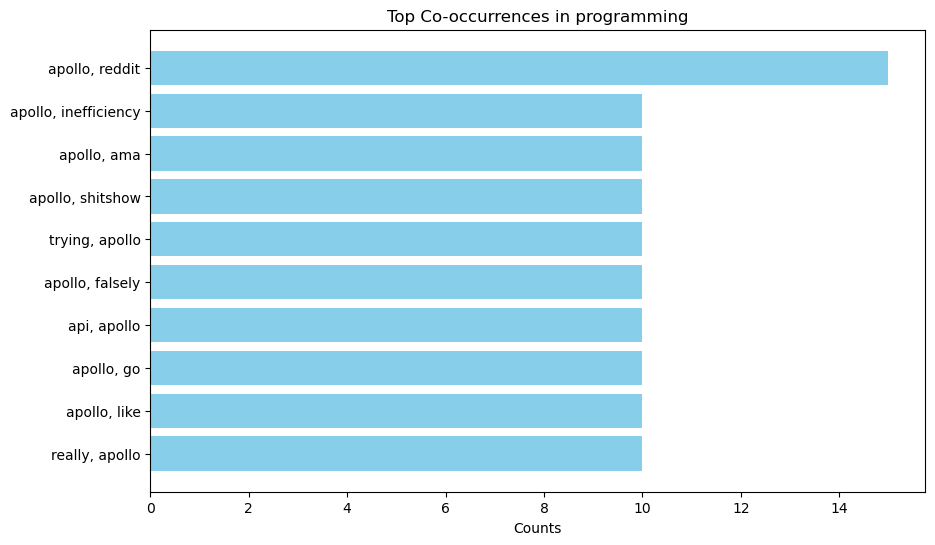

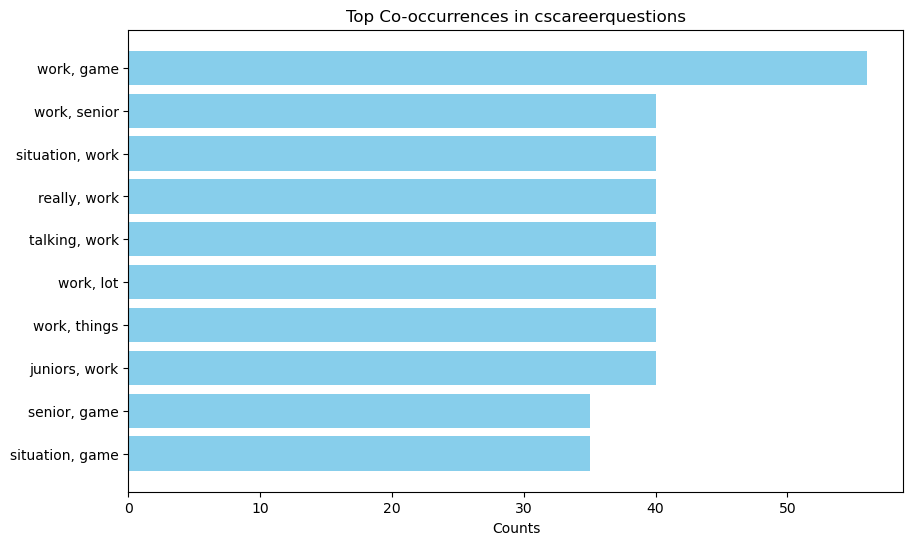

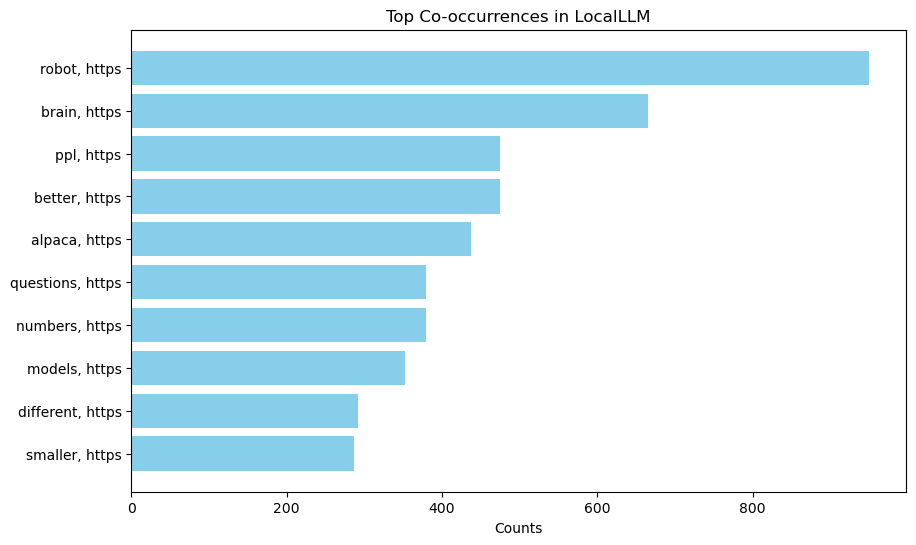

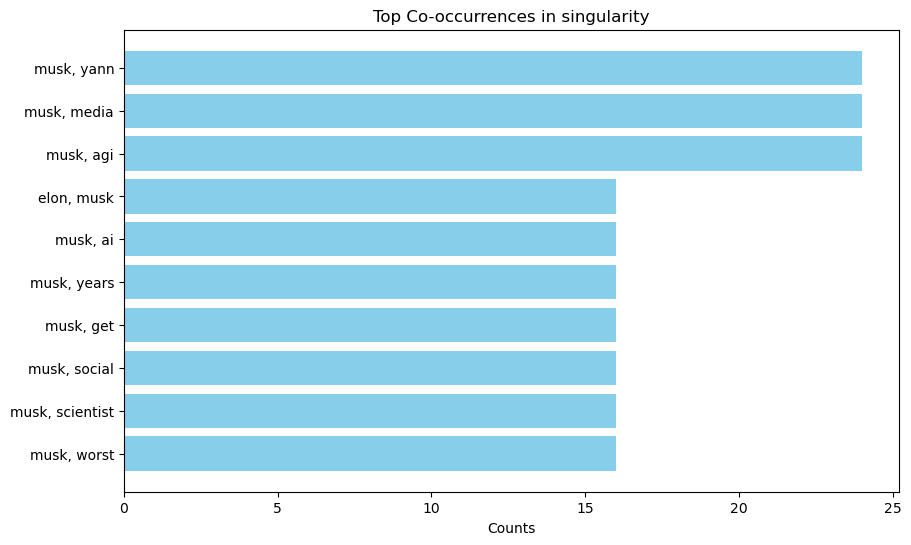

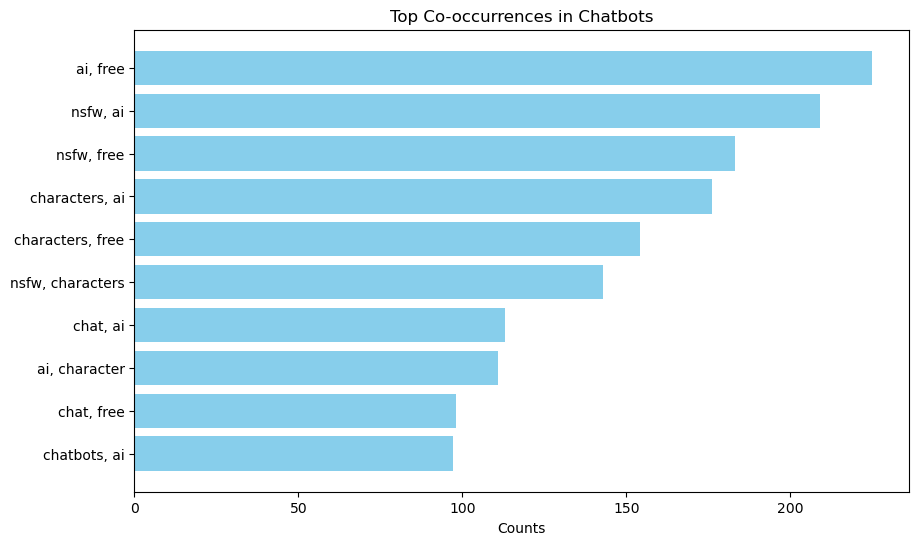

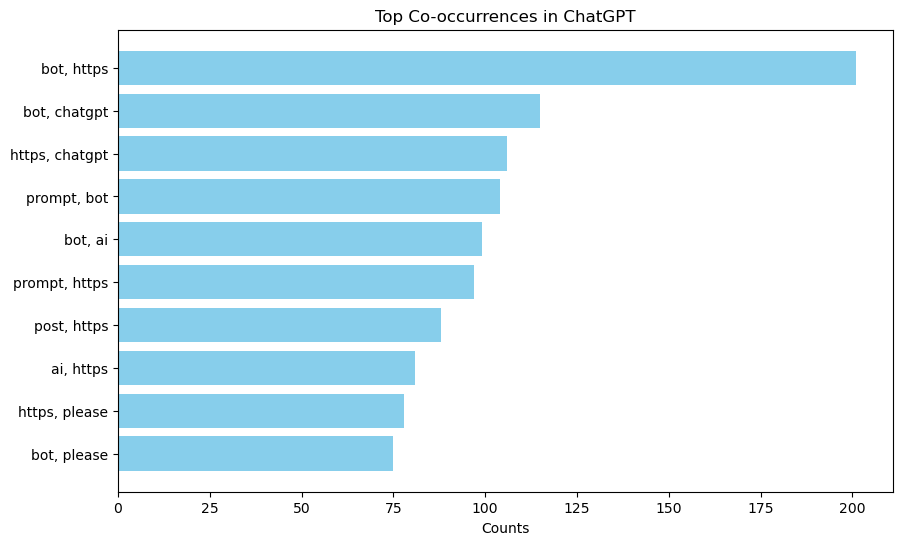

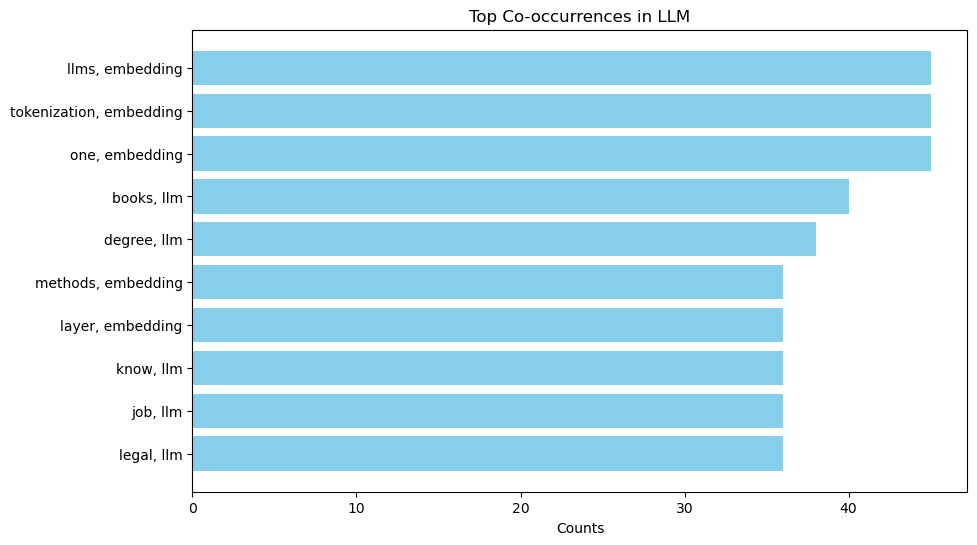

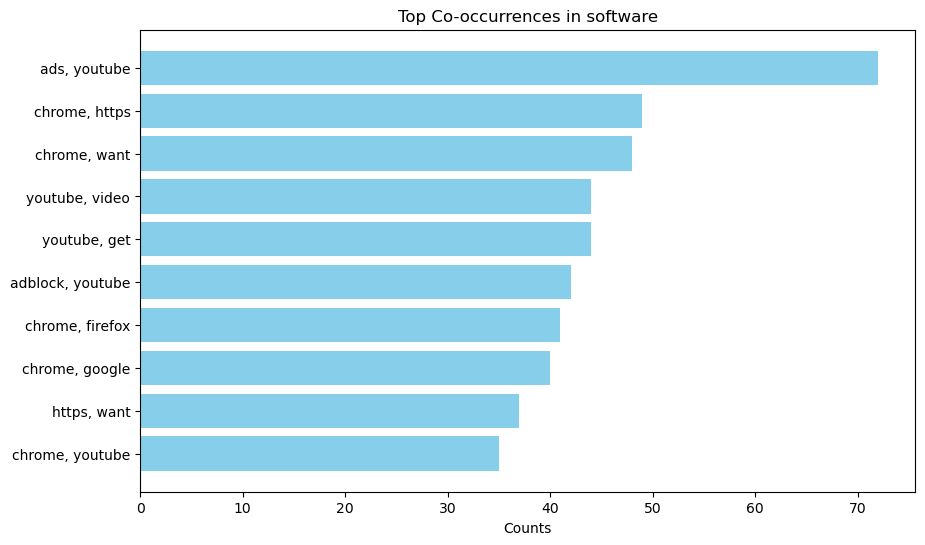

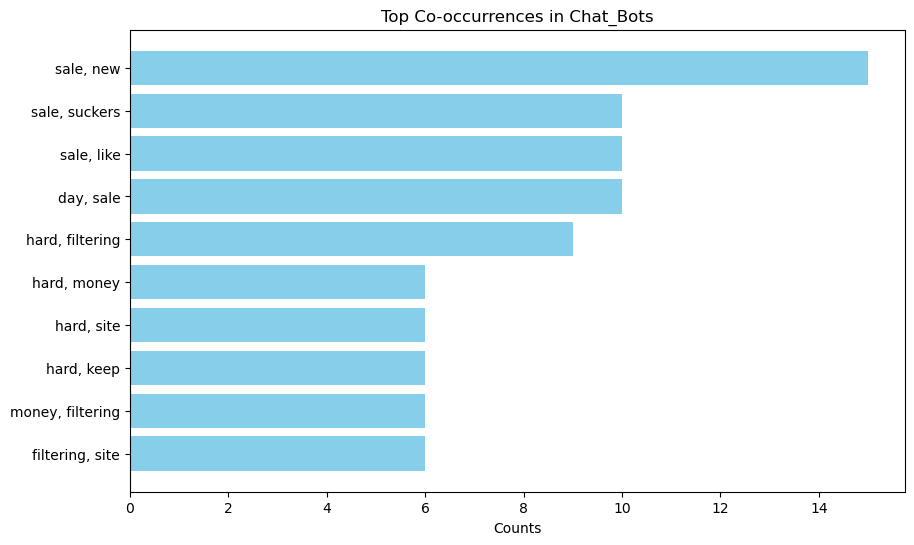

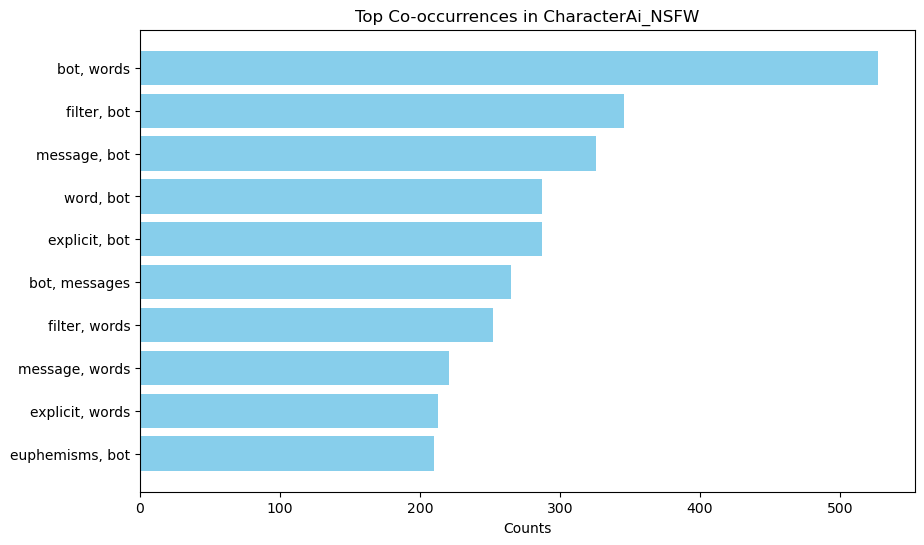

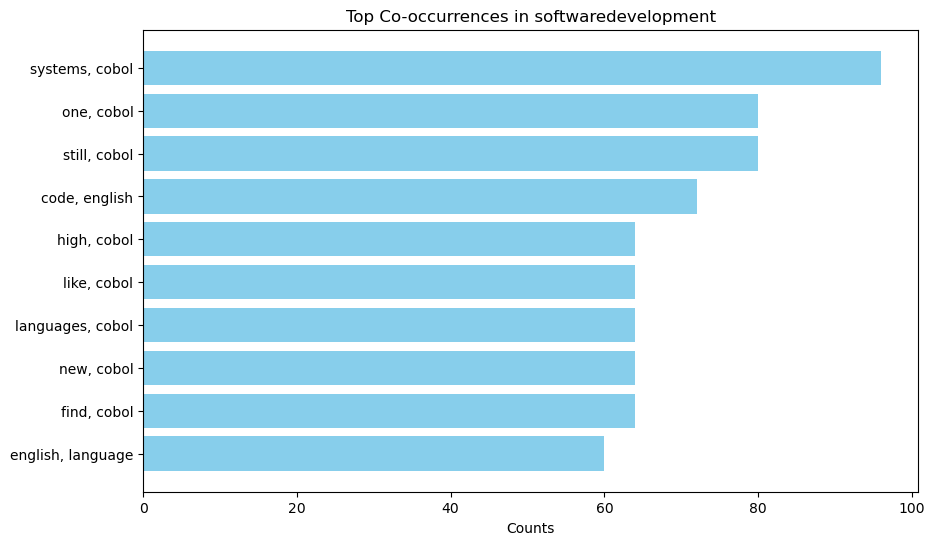

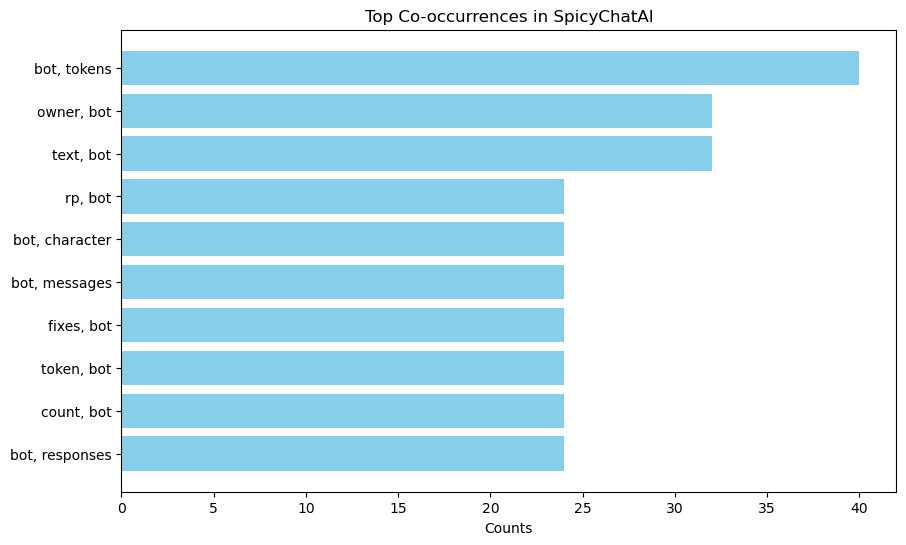

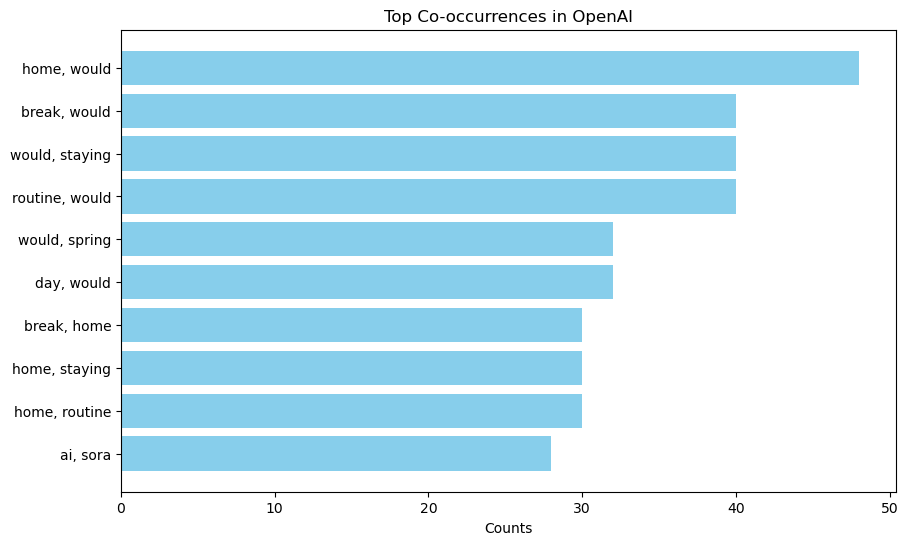

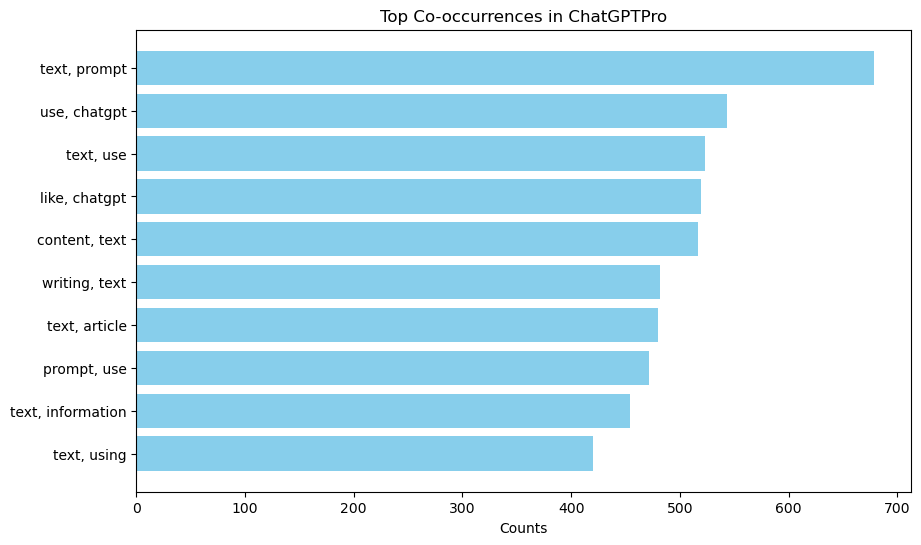

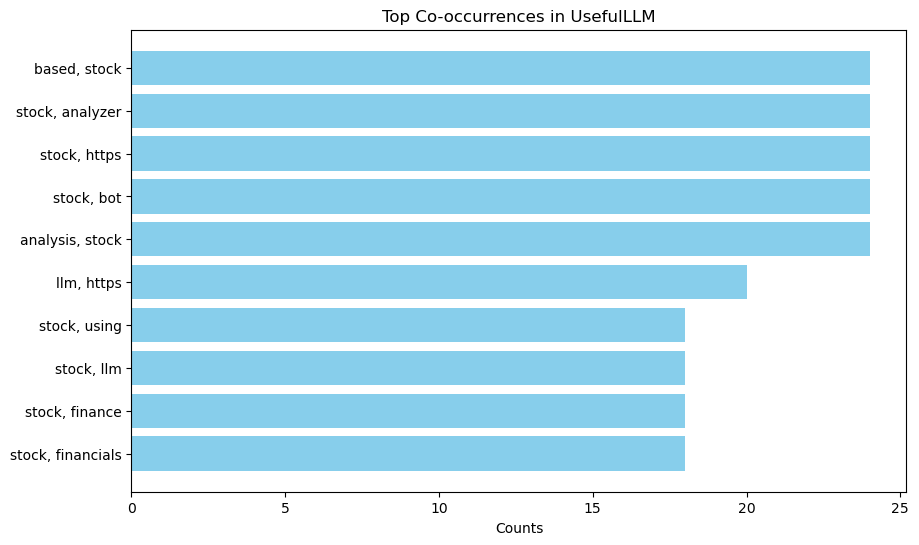

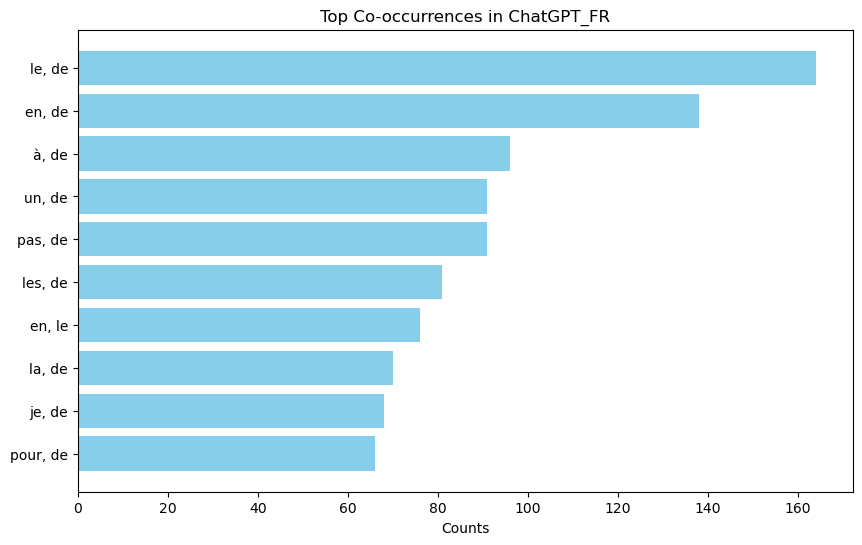

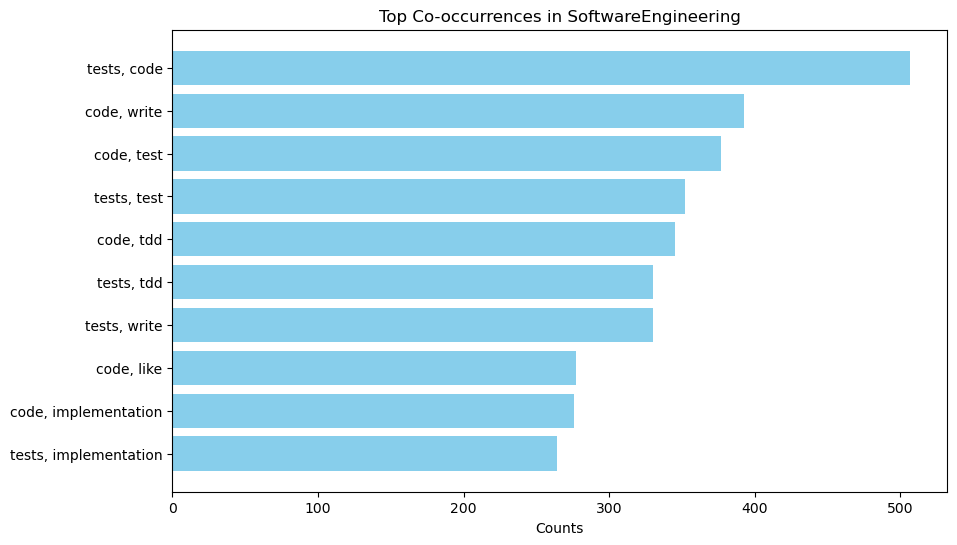

In [10]:
# Plot co-occurrence matrices
for subreddit, matrix in co_occurrences.items():
    sorted_matrix = dict(sorted(matrix.items(), key=lambda item: item[1], reverse=True)[:10])
    words = [', '.join(list(pair)) for pair in sorted_matrix.keys()]
    counts = list(sorted_matrix.values())

    plt.figure(figsize=(10, 6))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Counts')
    plt.title(f'Top Co-occurrences in {subreddit}')
    plt.gca().invert_yaxis()
    plt.show()

In [11]:
# Summary table of top 10 words and their frequencies
summary_df = pd.DataFrame(word_freq.most_common(10), columns=["Word", "Frequency"])
print(summary_df)

      Word  Frequency
0    https        268
1     like        166
2       ai        134
3      bot        116
4  chatgpt        103
5      use         87
6      one         86
7      get         85
8     also         74
9   prompt         73
